In [1]:
import iit.model_pairs as mp
import iit.utils.index as index
from circuits_benchmark.utils.get_cases import get_cases
from iit_utils import make_iit_hl_model, create_dataset
import random
from iit_utils.tracr_ll_corrs import get_tracr_ll_corr
from argparse import Namespace

/Users/cybershiptrooper/src/interpretability/MATS/.iit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
case_num = 3
args = Namespace(
    command='compile', 
    indices=f'{case_num}', 
    output_dir='/Users/cybershiptrooper/src/interpretability/MATS/circuits-benchmark/results', 
    device='cpu', 
    seed=1234, 
    run_tests=False, 
    tests_atol=1e-05, 
    fail_on_error=False, 
    original_args=['compile', f'-i={case_num}', '-f'])
cases = get_cases(args)
case = cases[0]
tracr_output = case.build_tracr_model()

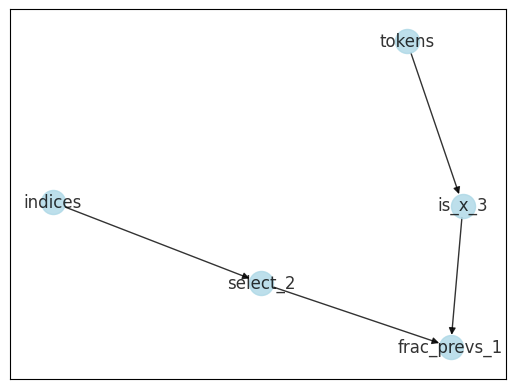

In [3]:
import networkx as nx
nx.draw_networkx(tracr_output.graph, with_labels=True, alpha=0.8, node_color='lightblue', font_color='black')

In [4]:
import pandas as pd
pd.read_csv('rough.csv')
import dataframe_image as dfi
dfi.export(pd.read_csv('rough.csv'), 'rough.png')

### AUROC

In [5]:
import pickle
weight = "510"
fnames = ["results/acdc_3/results_012heads.pkl", 
          "results/acdc_3/results_01heads.pkl", 
          "results/acdc_3/results_2head.pkl",
          "results/acdc_3/results_tracr.pkl"]
labels = ["3 heads", 
          "2 heads", 
          "1 head",
          "tracr"]
results = [pickle.load(open(fname, 'rb')) for fname in fnames]

In [6]:
def get_tpr_fpr_for_weight(results, weight):
    node_tpr = []
    node_fpr = []
    edge_tpr = []
    edge_fpr = []
    thresholds = []
    for k, v in results.items():
        if k[0] == weight:
            node_tpr.append(v['nodes']['tpr'])
            node_fpr.append(v['nodes']['fpr'])
            edge_tpr.append(v['edges']['tpr'])
            edge_fpr.append(v['edges']['fpr'])
            thresholds.append(k[1])
    return node_tpr, node_fpr, edge_tpr, edge_fpr, thresholds

In [7]:
tprs = []
fprs = []
edge_tprs = []
edge_fprs = []
thresholds = []
for result in results:
    node_tpr, node_fpr, edge_tpr, edge_fpr, th = get_tpr_fpr_for_weight(result, weight)
    if len(node_tpr) == 0:
        node_tpr, node_fpr, edge_tpr, edge_fpr, th = get_tpr_fpr_for_weight(result, "tracr") 
    tprs.append(node_tpr)
    fprs.append(node_fpr)
    edge_tprs.append(edge_tpr)
    edge_fprs.append(edge_fpr)
    thresholds.append(th)
    print(len(node_tpr), len(node_fpr), len(th), len(edge_tpr), len(edge_fpr))

12 12 12 12 12
12 12 12 12 12
12 12 12 12 12
12 12 12 12 12


In [8]:
from sklearn import metrics
node_auc = metrics.auc(node_fpr, node_tpr)
edge_auc = metrics.auc(edge_fpr, edge_tpr)
node_auc, edge_auc

(1.0, 1.0)

In [9]:
thresholds

[[0.0, 1e-05, 0.0001, 0.001, 0.025, 0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 10.0],
 [0.0, 1e-05, 0.0001, 0.001, 0.025, 0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 10.0],
 [0.0, 1e-05, 0.0001, 0.001, 0.025, 0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 10.0],
 [0.0, 1e-05, 0.0001, 0.001, 0.025, 0.01, 0.05, 0.1, 0.5, 0.8, 1.0, 10.0]]

In [10]:
# tracr_tpr = [0.0, 0.998, 1.0, 1.0, 1.0]
# tracr_fpr = [0.0, 0.0, 1.0, 1.0, 1.0]

# tprs.append(tracr_tpr)
# fprs.append(tracr_fpr)
# edge_tprs.append(tracr_tpr)
# edge_fprs.append(tracr_fpr)
# labels.append('tracr')

In [11]:
len(tprs)

4

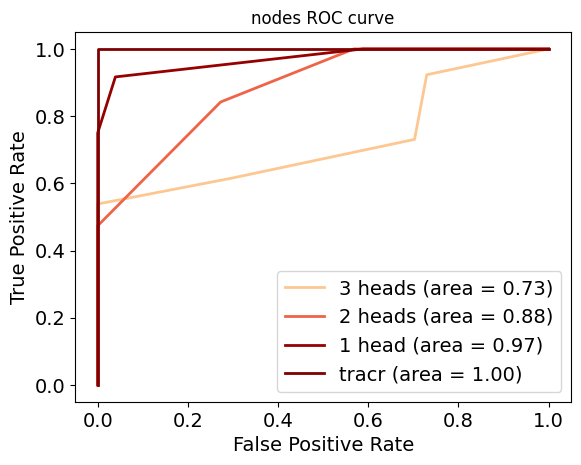

In [12]:
# plot ROC curve using node_tprs, node_fprs, edge_tprs, edge_fprs

def plot_roc_curve(tprs, fprs, title, labels=None):
    import matplotlib.pyplot as plt
    plt.figure()
    lw = 2
    for i, rates in enumerate(zip(tprs, fprs)):
        i += 1
        tpr_list, fpr_list = rates
        try:
            auc = metrics.auc(fpr_list, tpr_list)
        except ValueError:
            # make the list non-increasing by removing elements that are less than the previous
            # get indices where the list is decreasing
            tpr_indices = [idx for idx in range(1, len(tpr_list)) if tpr_list[idx] > tpr_list[idx-1]]
            fpr_indices = [idx for idx in range(1, len(fpr_list)) if fpr_list[idx] > fpr_list[idx-1]]
            all_indices = list(set(tpr_indices + fpr_indices))
            # sort descending so we can remove from the end
            all_indices.sort(reverse=True)
            for idx in all_indices:
                del tpr_list[idx]
                del fpr_list[idx]
            auc = metrics.auc(fpr_list, tpr_list)
            auc = metrics.auc(fpr_list, tpr_list)
        # plot with colorscheme viridis
        cmap = plt.get_cmap('OrRd')
        label = labels[i-1] if labels is not None else f"ROC curve {i}"
        plt.plot(fpr_list, tpr_list, lw=lw, label=f'{label} (area = {auc:.2f})', color=cmap(i*80))
    # auc = metrics.auc(fprs, tprs)

    # plt.plot(fprs, tprs, color='darkorange',
    #          lw=lw, label='ROC curve (area = %0.3f)' % auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title} ROC curve')
    plt.legend(loc="lower right")
    # increase font size of legend
    plt.legend(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    # increase font size of axis labels
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.show()

plot_roc_curve(tprs, fprs, 'nodes', labels)

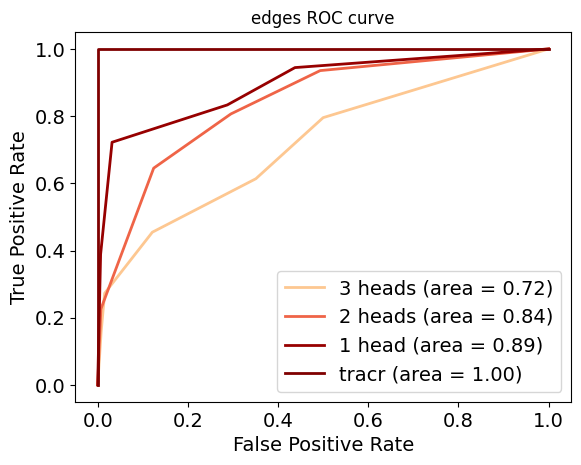

In [13]:
plot_roc_curve(edge_tprs, edge_fprs, 'edges', labels)

### Loss recovered

In [27]:
import pickle
weights = ["110", "510", "910", "100"]
fnames = ["results/acdc_3/result_01heads.pkl",]
labels = ["strict weight: 1", 
           "strict weight: 5", 
           "strict weight: 8",
           "natural"]
results = [pickle.load(open(fname, 'rb')) for fname in fnames]

In [28]:
list(results[0].values())[0]['current_metric']

5.144391924710896e-15

In [3]:
def get_current_metric_for_weight(results, weight):
    current_metric = []
    thresholds = []
    for k, v in results.items():
        if k[0] == weight:
            current_metric.append(v['current_metric'])
            thresholds.append(k[1])
    return current_metric, thresholds

In [ ]:
current_metrics = []
thresholds = []
for weight in weights:
    current_metric, th = get_current_metric_for_weight(result, weight)
    if len(current_metric) == 0:
        current_metric, th = get_current_metric_for_weight(result, "tracr") 
    current_metrics.append(current_metric)
    thresholds.append(th)
    print(len(current_metric), len(th))

Text(0, 0.5, 'Current metric')

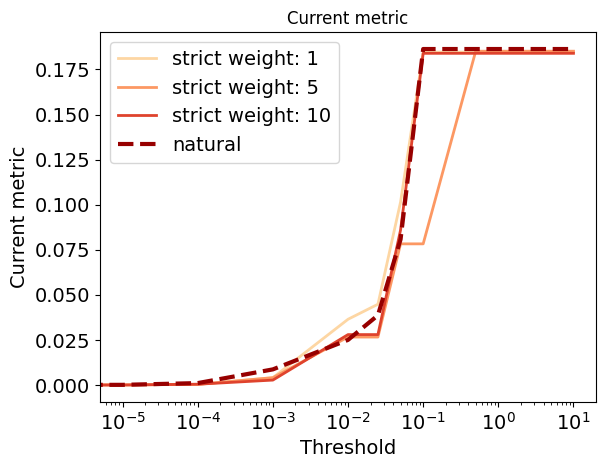

In [ ]:
# plot current metric using current_metrics, thresholds
import matplotlib.pyplot as plt
plt.figure()
lw = 2
cmap = plt.get_cmap('OrRd')
for i, rates in enumerate(zip(current_metrics, thresholds)):
    i += 1
    metric_list, th_list = rates
    # sort metric_list and th_list according to th_list
    metric_list, th_list = zip(*sorted(zip(metric_list, th_list)))
    label = labels[i-1] if labels is not None else f"current metric {i}"
    if label == "natural":
        # highlight the plot with the highest weight
        plt.plot(th_list, metric_list, lw=lw+1, label=label, color=cmap(i*60), linestyle='--')
    else:
        # plot log scale
        plt.plot(th_list, metric_list, lw=lw, label=label, color=cmap(i*60))
    plt.xscale('log')

plt.xlabel('Threshold')
plt.ylabel('Current metric')
plt.title('Current metric')
# increase font size everywhere
plt.legend(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Current metric', fontsize=14)


per head

In [1]:
import pickle
weight = "510"
fnames = [
    "results/acdc_3/results_3heads.pkl", 
    "results/acdc_3/results_2heads.pkl", 
    # "results/acdc_3/results_1head.pkl",
    # "results/acdc_3/results_tracr.pkl"
    ]
labels = ["3 heads", 
          "2 heads", 
          "1 head",
          "tracr"]
results = [pickle.load(open(fname, 'rb')) for fname in fnames]

In [4]:
current_metrics = []
thresholds = []
for result in results:
    current_metric, th = get_current_metric_for_weight(result, weight)
    if len(current_metric) == 0:
        current_metric, th = get_current_metric_for_weight(result, "tracr") 
    current_metrics.append(current_metric)
    thresholds.append(th)
    print(len(current_metric), len(th))

12 12
12 12


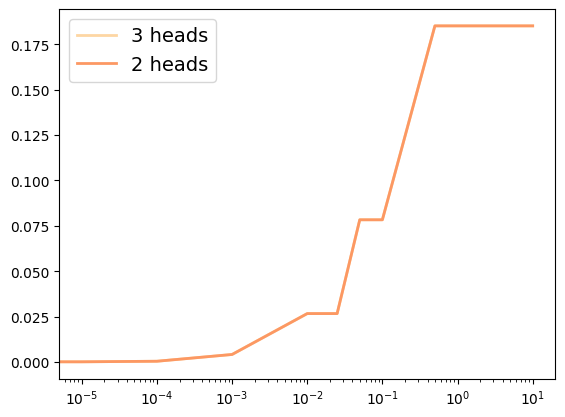

In [6]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
cmap = plt.get_cmap('OrRd')

for i, rates in enumerate(zip(current_metrics, thresholds)):
    i += 1
    metric_list, th_list = rates
    # sort metric_list and th_list according to th_list
    metric_list, th_list = zip(*sorted(zip(metric_list, th_list)))
    label = labels[i-1] if labels is not None else f"current metric {i}"
    if label == "tracr":
        # highlight the plot with the highest weight
        plt.plot(th_list, metric_list, lw=lw+1, label=label, color=cmap(i*60), linestyle='--')
    else:
        # plot log scale
        plt.plot(th_list, metric_list, lw=lw, label=label, color=cmap(i*60))
    plt.xscale('log')
    plt.legend(fontsize=14)